<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [26]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [27]:
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
df.head()

date   close
0 1986-01-02  209.59
1 1986-01-03  210.88
2 1986-01-06  210.65
3 1986-01-07  213.80
4 1986-01-08  207.97

In [28]:
df.shape

(8192, 2)

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [30]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Task 4: Create Training and Test Splits

In [32]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [33]:
time_steps = 30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)

print(X_train.shape)

(6523, 30, 1)


In [34]:
X_train

array([[[-1.51611822],
        [-1.51302665],
        [-1.51357786],
        ...,
        [-1.50018105],
        [-1.50094795],
        [-1.50082812]],

       [[-1.51302665],
        [-1.51357786],
        [-1.50602867],
        ...,
        [-1.50094795],
        [-1.50082812],
        [-1.49740103]],

       [[-1.51357786],
        [-1.50602867],
        [-1.52000066],
        ...,
        [-1.50082812],
        [-1.49740103],
        [-1.49174513]],

       ...,

       [[ 1.00394471],
        [ 1.03941391],
        [ 0.92720661],
        ...,
        [ 0.89521243],
        [ 0.90458301],
        [ 0.87028812]],

       [[ 1.03941391],
        [ 0.92720661],
        [ 0.95258626],
        ...,
        [ 0.90458301],
        [ 0.87028812],
        [ 0.95644473]],

       [[ 0.92720661],
        [ 0.95258626],
        [ 1.01048734],
        ...,
        [ 0.87028812],
        [ 0.95644473],
        [ 0.96224443]]])

## Task 5: Build an LSTM Autoencoder

In [35]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Task 6: Train the Autoencoder

In [37]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
184/184 [==============================] - 13s 72ms/step - loss: 0.1652 - val_loss: 0.1742
Epoch 2/100
184/184 [==============================] - 12s 67ms/step - loss: 0.1136 - val_loss: 0.0572
Epoch 3/100
184/184 [==============================] - 12s 66ms/step - loss: 0.0901 - val_loss: 0.0524
Epoch 4/100
184/184 [==============================] - 13s 69ms/step - loss: 0.0808 - val_loss: 0.0530
Epoch 5/100
184/184 [==============================] - 12s 67ms/step - loss: 0.0762 - val_loss: 0.0427
Epoch 6/100
184/184 [==============================] - 12s 65ms/step - loss: 0.0773 - val_loss: 0.0486
Epoch 7/100
184/184 [==============================] - 12s 65ms/step - loss: 0.0754 - val_loss: 0.0768
Epoch 8/100
184/184 [==============================] - 12s 64ms/step - loss: 0.0765 - val_loss: 0.0380
Epoch 9/100
184/184 [==============================] - 12s 66ms/step - loss: 0.0715 - val_loss: 0.0283
Epoch 10/100
184/184 [==============================] - 12s 66ms/step - l

## Task 7: Plot Metrics and Evaluate the Model

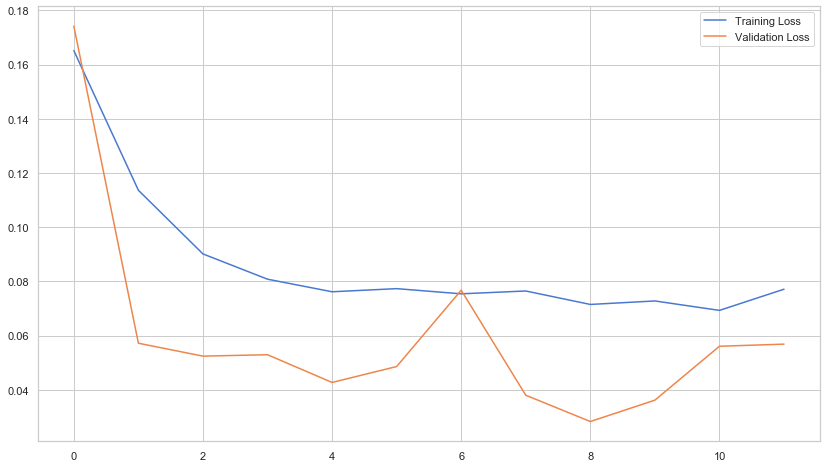

In [38]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [39]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [40]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 2s 39ms/step - loss: 0.3637


0.36365047097206116

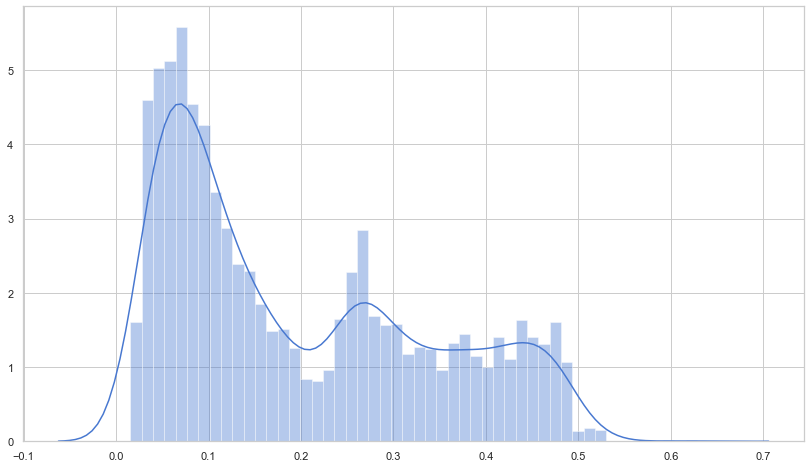

In [41]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [42]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

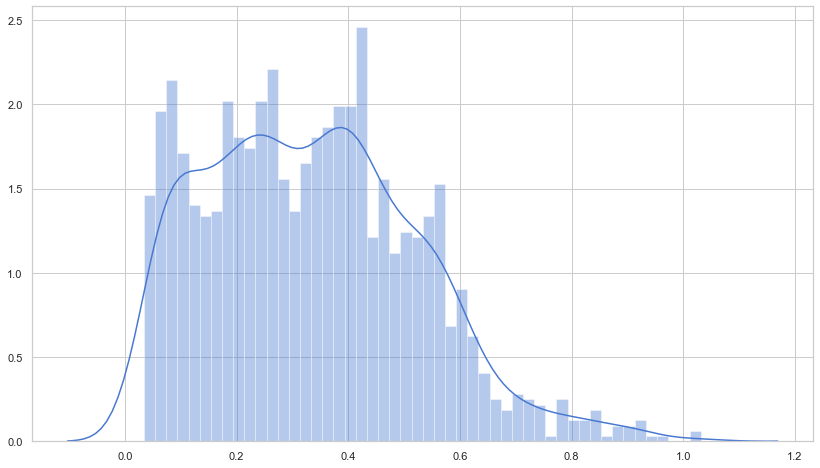

In [43]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [44]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [46]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

date     close      loss  threshold  anomaly
7474 2015-08-25  2.457439  0.721399       0.65     True
7475 2015-08-26  2.632149  0.789023       0.65     True
7476 2015-08-27  2.745147  0.697442       0.65     True
8090 2018-02-05  4.329949  0.729001       0.65     True
8091 2018-02-06  4.440671  0.899475       0.65     True

In [47]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()